## Lesson 6 - Python version

In this lesson we will start to explore dynamics at your site of interest by plotting the results from the simulation run in lesson 5. This requires plotting history outputs that are indexed by site, pft, and size. All outputs in FATES are output as one dimensional vectors, meaning we have to untangle them in order to make sense of the simulated dynamics. To do this we make use of the function below. This function takes an output that is in the from 

pft_1_size_1, pft_1_size_2, pft_1_size_3 ... pft_1_maxsize, pft_2_size_1, pft_2_size_2, pft_2_maxsize ... 

and converts to a multi-dimensional array. 


In [1]:
def szpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)


### Libraries

In [2]:
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Make some colours for plotting

In [3]:
dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

### Load the FATES run

In [8]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fates-tute-runs/bci/fates-tutorial-bci-2pfts.Edf989f750d-Fb8e4eee5.2024-08-09/run/fates-tutorial-bci-2pfts.Edf989f750d-Fb8e4eee5.2024-08-09.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time'])/12)
print(nyears)
time = fates.variables['time'] / 365.

tave_start = (nyears*12-2*12)
tave_stop = nyears*12

cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)
patch_age_bins = fates.variables['fates_levage'][:]

23


### Plotting multi-dimensional FATES outputs

As an example let's look at the 'FATES_VEGC_SZPF' output. This is the total aboveground vegetation biomass in live plants in Kg C m-2. The _SZPF ending tells us that it is output along a size by pft dimension. We can use the szpf_to_scls_by_pft function to turn it into an array, rather than a one dimensional output. 

In [10]:
VEGC_PF = szpf_to_scls_by_pft(fates.FATES_VEGC_SZPF, fates) # convert to multidimensional array
VEGC_PF = VEGC_PF.sum(dim='fates_levscls') # sum up over the size dimensions so we have total vegetation carbon by PFT through time

print(VEGC_PF.shape)
print(VEGC_PF.dims)

(279, 2, 1)
('time', 'fates_levpft', 'lndgrid')


### Exploring PFT competitive-dynamics

If we plot AGB through time by PFT we can see how PFT dominance changes through time and whether we have coexistence of our PFTs. 
Using Xarray we can specify which PFT we want to plot using the isel argument. 

We can also look at the number of stems through time of each PFT. 

''

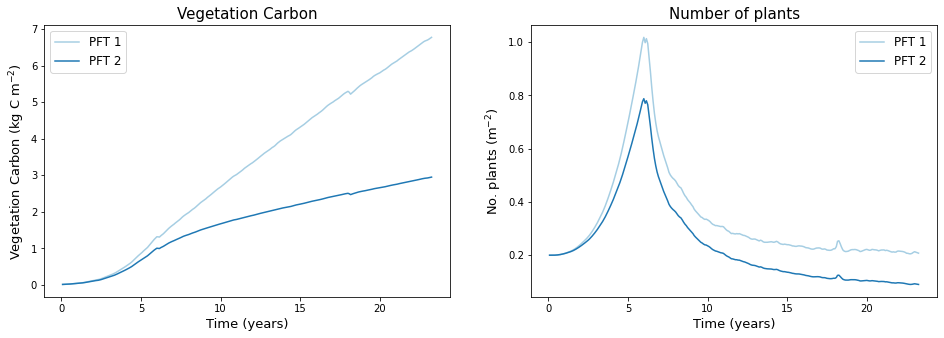

In [11]:
fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

f1ax0.plot(time, VEGC_PF.isel(fates_levpft=0), color=colormap[0], label = 'PFT 1')
f1ax0.plot(time, VEGC_PF.isel(fates_levpft=1), color=colormap[1], label = 'PFT 2')
f1ax0.set_title(r'Vegetation Carbon', fontsize = 15)
f1ax0.set_ylabel(r'Vegetation Carbon (kg C m$^{-2}$)', fontsize = 13)
f1ax0.set_xlabel(r'Time (years)', fontsize = 13) 
f1ax0.legend(prop={'size':12})

NPLANT_PF = szpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates) # convert to multidimensional array
NPLANT_PF = NPLANT_PF.sum(dim='fates_levscls') # sum up over the size dimensions so we have total vegetation carbon by PFT through time

f1ax1.plot(time, NPLANT_PF.isel(fates_levpft=0), color=colormap[0], label = 'PFT 1')
f1ax1.plot(time, NPLANT_PF.isel(fates_levpft=1), color=colormap[1], label = 'PFT 2')
f1ax1.set_title(r'Number of plants', fontsize = 15)
f1ax1.set_ylabel(r'No. plants (m$^{-2}$)', fontsize = 13)
f1ax1.set_xlabel(r'Time (years)', fontsize = 13)    
f1ax1.legend(prop={'size':12})
;

Looking at the growth and mortality rates of each PFT can give us insight into why one PFT might be out competing the other. 

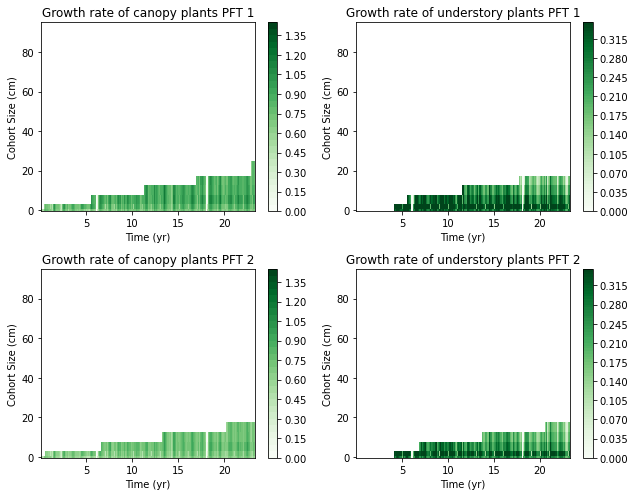

In [16]:
NPLANT_CANOPY_SZPF = szpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates) 
NPLANT_USTORY_SZPF = szpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates)

DDBH_CANOPY_SZPF = szpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates) * 100 # convert to cm
DDBH_USTORY_SZPF = szpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates) * 100 # convert to cm

MORT_CANOPY_SZPF = szpf_to_scls_by_pft(fates.FATES_MORTALITY_CANOPY_SZPF, fates)
MORT_USTORY_SZPF = szpf_to_scls_by_pft(fates.FATES_MORTALITY_USTORY_SZPF, fates)

# set up the page
fig3, ((f3ax0, f3ax1), (f3ax2, f3ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: growth rate (in diameter increment) in the canopy
levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax0.pcolormesh(time, cohort_size_bins, np.squeeze(DDBH_CANOPY_SZPF.isel(fates_levpft=0) / NPLANT_CANOPY_SZPF.isel(fates_levpft=0)).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'Growth rate of canopy plants PFT 1')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')

## set up the second plot: growth rate in the understory, units as above
levels = np.arange(0.,0.35, 0.005)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax1.pcolormesh(time, cohort_size_bins, np.squeeze(DDBH_USTORY_SZPF.isel(fates_levpft=0) / NPLANT_USTORY_SZPF.isel(fates_levpft=0)).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'Growth rate of understory plants PFT 1')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')

levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax2.pcolormesh(time, cohort_size_bins, np.squeeze(DDBH_CANOPY_SZPF.isel(fates_levpft=1) / NPLANT_CANOPY_SZPF.isel(fates_levpft=1)).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'Growth rate of canopy plants PFT 2')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')

## set up the second plot: growth rate in the understory, units as above
levels = np.arange(0.,0.35, 0.005)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax3.pcolormesh(time, cohort_size_bins, np.squeeze(DDBH_USTORY_SZPF.isel(fates_levpft=1) / NPLANT_USTORY_SZPF.isel(fates_levpft=1)).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.set_title(r'Growth rate of understory plants PFT 2')
f3ax3.set_xlabel('Time (yr)')
f3ax3.set_ylabel('Cohort Size (cm)')

fig3.tight_layout()











# ## set up the third plot: mortality rate in the canopy, in units of fraction of trees per year of a given size class and canopy position
# levels = np.arange(0.,0.1, 0.01)
# cmap = plt.get_cmap('Reds')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# im = f3ax2.pcolormesh(time, cohort_size_bins, np.squeeze(MORT_CANOPY_SZ / NPLANT_CANOPY_SZ).transpose(), cmap=cmap, norm=norm)
# fig3.colorbar(im, ax=f3ax2)
# f3ax2.set_title(r'Mortality rate of canopy plants (yr$^{-1}$)')
# f3ax2.set_xlabel('Time (yr)')
# f3ax2.set_ylabel('Cohort Size (cm)')

# ## set up the fourth plot: mortality rate in the understory, units as above
# levels = np.arange(0.,1.0, 0.1)
# cmap = plt.get_cmap('Reds')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# im = f3ax3.pcolormesh(time, cohort_size_bins, np.squeeze(MORT_UNDERSTORY_SZ / NPLANT_UNDERSTORY_SZ).transpose(), cmap=cmap, norm=norm)
# fig3.colorbar(im, ax=f3ax3)
# f3ax3.set_title(r'Mortality rate of understory plants (yr$^{-1}$)')
# f3ax3.set_xlabel('Time (yr)')
# f3ax3.set_ylabel('Cohort Size (cm)')

